In [237]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Generic libraries
import bluesquare_data_pipelines.access as blsq
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import warnings
import random
from dask import delayed

import geopandas as gpd
import json
from dateutil.relativedelta import relativedelta

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

warnings.filterwarnings('ignore')

get_new_data = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
print("DATA READ")
print("\n Connect to DHIS")
snis = blsq.dhis_instance("dhis2_drc_snis_replica")
shape = snis.get_geodataframe(level=3, type_shape = "polygons")

print("\n Building Geographic Shapefile")
shape = shape.rename({"uid":"id"}, axis=1)
shape.to_file("drc_shape.json", driver='GeoJSON')
    
if get_new_data == False:
    income = pd.read_csv("../data/income.csv")
    spending = pd.read_csv("../data/spending.csv")
    out_patients = pd.read_csv("../data/out_patients.csv")
    state_payments = pd.read_csv("../data/state_payments.csv")
    balance = pd.read_csv("../data/balance.csv")
    hr = pd.read_csv("../data/hr_data.csv")
    
if get_new_data == True:    
    print("\n Extract Income Data")
    income = snis.sql_read("../get_province_income.sql")
    income["year"] =  pd.to_datetime(income.period_end).dt.year
    balance = income[income.data_element_name == "A 4.4 Solde début de mois"]
    income = income[~(income.data_element_name == "A 4.4 Solde début de mois")]

    print(" \n Extract Spendings Data")
    spending = snis.sql_read("../get_province_spending.sql")
    spending["year"] = pd.to_datetime(spending.period_end).dt.year
    
    print(" \n Extract HR Data")
    hr = snis.sql_read("../get_HR_data.sql")
    hr["year"] = pd.to_datetime(hr.period_end).dt.year
    hr["category"] = ""
    hr.category[hr.data_element_name.str.contains(" Jours de travail prévus| travail prevu")] = "Jours de travail prévus"
    hr.data_element_name = hr.data_element_name.str.replace(" Jours de travail prévus| travail prevu", "")

    hr.category[hr.data_element_name.str.contains(" Jours de travail préstés| travail preste")] = "Jours de travail presté"
    hr.data_element_name = hr.data_element_name.str.replace(" Jours de travail préstés| travail preste", "")

    hr.category[hr.data_element_name.str.contains(" Jours d'absences justifiées| abs justifie")] = "Jours d'absence justifiés"
    hr.data_element_name = hr.data_element_name.str.replace(" Jours d'absences justifiées| abs justifie", "")

    hr.category[hr.data_element_name.str.contains(" Agents| agents")] = "Agents"
    hr.data_element_name = hr.data_element_name.str.replace(" Agents| agents| -", "")
    
    print("\n Extract Outpatients Data")
    out_patients = snis.sql_read("../get_outpatients.sql")
    out_patients["year"] = pd.to_datetime(out_patients.period_end).dt.year
    
    print("\n Extract State Payments Data")
    state_payments = snis.sql_read("../get_province_state_payment.sql")
    state_payments["year"] = pd.to_datetime(state_payments.period_end).dt.year
    
    print("\n Write data")
    income.to_csv("../data/income.csv")
    spending.to_csv("../data/spending.csv")
    out_patients.to_csv("../data/out_patients.csv")
    state_payments.to_csv("../data/state_payments.csv")
    balance.to_csv("../data/balance.csv")
    hr.to_csv("../data/hr_data.csv")
    
with open('drc_shape.json') as response:
    drc_shape = json.load(response)

for i in range(len(drc_shape["features"])):
    drc_shape["features"][i]["id"] = drc_shape["features"][i]["properties"]["id"]

DATA READ

 Connect to DHIS
Failed connection
Getting Orgunits


AttributeError: 'dhis_instance' object has no attribute 'connexion'

In [3]:
def get_n_facility_month(data):
    return str(data.groupby(["period_end"]).fosa_id.nunique().sum())
    
print("     N facility month for income data: " + get_n_facility_month(income))
print("     N facility month for spending data: " + get_n_facility_month(spending))
print("     N facility month for outpatient data: " + get_n_facility_month(out_patients))
print("     N facility month for state payments data: " + get_n_facility_month(state_payments))
print("     N facility month for HR data: " + get_n_facility_month(hr))

     N facility month for income data: 425555
     N facility month for spending data: 436760
     N facility month for outpatient data: 528290
     N facility month for state payments data: 314412
     N facility month for HR data: 490577


# Description of data in the SNIS

## Facilities budget

* __Revenue -__ Section 4.4 lists the value of the different incomes received by the facility. These include:
    * _Direct Payment_, which are out of pocket payments from patients
    * _Third Party Payment_, which are payments received from a variety of schemes (Results Based Financing, insurance schemes...)
    * _Other subsidies_, which are subventions received from a partner (NGO, faith based organisation...)
    * _Other payments_, which are payments received from other sources. It not clear what that could be.

<img src="img/incomes.png" align="center"/>

* __Spendings -__ Section 4.5 describes the different types of spending that have been made. These can be categorized as :
    * _Human Resource_, for Prime Locale (sharing of health facility income among health workers) and transport personnel.
    * _Procurement_, for drugs and consommables, varied inputs and non stockables resources
    * _Financial costs_, which include taxes, investments and banking costs
    * _Other_
    
<img src="img/spendings.png" align="center"/>

* __State Payments -__ Section 4.6 presents the payments that are received from the state. These are of two kinds.
    * _Salary_ which are payed to health workers that have been registered in the MOH payroll as permanent workers.
    * _Prime_ which is payed to every health workers, independently of its actual status 
    
<img src="img/indirect_payments.png" align="center"/>

We measure the budget of health facilities using both a revenue based approach and a spendings based approach. In both cases, we include the state payments.

<img src="img/hr.png" align="center"/>

## Services activity

Health Facilities report on the number of cases they have received. This aggregated does not give any indication on the case mix. As a first approximation, we still use this indicator to analyse the activity in a health facility. A deeper dive into case mix could be made in later iteration using the more details on the different type of cases seen in consultation as out and in patients.

<img src="img/cas_recus.png" align="center"/>



# Data Availability

The nature of the SNIS data makes it hard to assess data quality on an aggregated basis. Data is indeed very fragmented (over 12000 health facilities reporting on a variety of data elements on a monthly basis), and presents non random sources of variability. For example, when looking at the salaries being paid by the central state (see below), we see the payment of this salary is not continuous, but happens in waves. By opposition, the _Prime de l'Etat_ is being paid on a much more continuous basis. This makes it very difficult to evaluate data quality on this variable, as a given payment represents a catch-up on past payments.

In [320]:
@interact
def plot_distrib(province = ["National"] + list(spending.province_name.unique())):
    if (province == "National") is True:
        data_plot = state_payments.groupby(["period_end", "data_element_name"]).value.sum().unstack().reset_index()
    if (province == "National") is False:
        dat = state_payments[state_payments.province_name == province]
        data_plot = dat.groupby(["period_end", "data_element_name"]).value.sum().unstack().reset_index()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                x=data_plot.period_end,
                y=0.00060 *data_plot["A 4.6 Prime de l'Etat"],
                name="Prime de l'état",
                line_color='deepskyblue',
                opacity=0.8))

    fig.add_trace(go.Scatter(
                x=data_plot.period_end,
                y=0.00060 *data_plot["A 4.6 Salaire de l'Etat"],
                name="Salaire de l'état",
                line_color='dimgray',
                opacity=0.8))
    fig.update_layout(title_text="Payments amounts - " + province + " (USD)")
    fig.show()

interactive(children=(Dropdown(description='province', options=('National', 'it Ituri Province', 'kr Kasai Cen…

We use Isolation Forests to detect outliers. Isolation Forests are an efficient way to identify outliying observations with minimal assumptions on the data's expected distribution. We procede as follows:

1. We aggregate the extracted data from different variables. This means we sum all income data together and all spending data together for each period in each facility.
2. We combine the different variables together, in order to get the set of fully observed data points that will be 
3. We fit the isolation forest algorithm separately for each facility, using recorded income, recorded spending and case load as relevant dimensions. Doing so, we identify observations in which the relation between those three variables diverges from what it is, for the same facility, in other reporting periods.

The result of this process will be to center the observations we have on the most frequent domain. Doing so, we may underestimate the actual variability in our analysis. We will have to correct this bias analyzing the sensibility of our results to outliers in the later steps of our analysis.

In [5]:
aggr_dims = ["province_name","zone_id","fosa_id","year","period_end","period"]

print("Series aggregation")
print("  Income")
income_enddate = income.groupby(aggr_dims).value.sum().reset_index()
print("  Spending")
spending_enddate = spending.groupby(aggr_dims).value.sum().reset_index()
print("  Cases seen")
out_patients_enddate = out_patients.groupby(aggr_dims).value.sum().reset_index()
print("  State payments")
state_payments_enddate = state_payments.groupby(aggr_dims).value.sum().reset_index()
print("  Balance and balance lag")
balance_lag = balance.copy()
balance_lag["period_end"] = ((pd.to_datetime(balance_lag["period_end"]) - pd.Timedelta(32, unit="d")) +  MonthEnd(1)).dt.date
balance_lag = balance_lag[["value","province_name","period_end","zone_id","fosa_id"]]
balances = balance_lag.merge(balance, on = ["province_name","period_end","zone_id","fosa_id"], suffixes = ["_end", "_start"], how="right")


print("Combining all series except balance")
full_dat_enddate = out_patients_enddate.merge(spending_enddate, on = aggr_dims, suffixes=["_opv", 
                                                                                          "_spending"]).merge(income_enddate,
                                                                                                             on = aggr_dims).merge(state_payments_enddate,
                                                                                                                                               on = aggr_dims,
                                                                                                                                               suffixes=["_revenue","_state_payment"])                                               

Series aggregation
  Income
  Spending
  Cases seen
  State payments
  Balance and balance lag
Combining all series except balance


In [326]:
out_patients_enddate.fosa_id.nunique()

17671

In [6]:
from plotly.subplots import make_subplots
from ipywidgets import AppLayout, Button, Layout


def get_completeness(province, period, outliers):
    dat = full_dat_enddate[(full_dat_enddate.province_name.isin(province)) & (full_dat_enddate.period_end >= period[0]) & 
                           (full_dat_enddate.period_end <= period[1]) ]
    if (outliers == 'dropping ouliers'):
        dat = dat[dat.outlier == 1]
    
    
    province_timeline = (dat.groupby(["period_end","province_name"]).apply(len) / out_patients.groupby(["province_name"]).fosa_id.nunique()).reset_index()
    province_timeline = province_timeline.rename({0:"value"}, axis = 1)
    
    n_month = (pd.to_datetime(period[1]).year - pd.to_datetime(period[0]).year) * 12 + pd.to_datetime(period[1]).month - pd.to_datetime(period[0]).month
    zone_map = (dat.groupby(["province_name","zone_id"]).apply(len) /( n_month * out_patients.groupby(["province_name","zone_id"]).fosa_id.nunique())).reset_index()
    zone_map = zone_map.rename({0:"value"}, axis = 1)
    
    indicator = len(dat) / (n_month * out_patients[out_patients.province_name.isin(province)].fosa_id.nunique())
    return (province_timeline, zone_map, indicator)
    
    
def make_graph(province, period, outliers):
    data_for_plot = get_completeness(province, period, outliers)
    province_timeline = data_for_plot[0]
    zone_map = data_for_plot[1]
    indicator = data_for_plot[2]
    
    fig = make_subplots(rows=2, cols=2, column_widths=[0.5, 0.5],
                        specs=[[{"type": "xy"}, {"type": "mapbox", "rowspan": 2}],
                              [{"type": "domain"}, None]],
    subplot_titles=("","", "% Availability")
                       )
    zone_map = zone_map.merge(shape[["uidlevel3","namelevel3"]], left_on="zone_id", right_on="uidlevel3")

    max_y = province_timeline.value.max()
    for province_name in province: 
        dat_plot = province_timeline[province_timeline.province_name == province_name]
        fig.add_trace(
            go.Scatter(x=dat_plot.period_end, y=dat_plot.value, name = province_name),
            row=1, col=1, 
        )
    
    fig.add_trace(go.Indicator(
        mode = "number",
        value = indicator), row= 2, col= 1)
    
    fig.add_trace(
        go.Choroplethmapbox(geojson=drc_shape, locations=zone_map.zone_id, 
                                    z=zone_map.value,
                                    colorscale="RdBu",
                                    hoverinfo="all",
                                    text = zone_map['namelevel3'],
                                    hovertemplate = '<b>Zone</b>: <b>%{text}</b>'+
                                                    '<br> <b>N Fosa </b>: %{z}<br>',
                                    marker_opacity=0.5, marker_line_width=0, name="Zones"),
            row=1, col=2)
    
    fig.update_layout(mapbox_style="carto-positron",
                      mapbox_zoom=4, mapbox_center = {"lat": -4, "lon": 22})
    
    fig.update_yaxes(range=[0, 1])

    fig.update_layout(height=600, width=1200, showlegend=False)
    fig.show()

We now consider the availability of data with and without outliers. 

In [8]:
%%time 
print("Running Outliers Detection")
isolation_forest = IsolationForest(contamination=.1)

def spot_fosa_outlier(data, isolation_forest=isolation_forest):
    data["outlier"] = 1
    if len(data) > 2:
        fit_data = data[["value_revenue","value_spending","value_opv"]]
        data["outlier"] = isolation_forest.fit_predict(fit_data)
    return data

full_dat_enddate = full_dat_enddate.groupby("fosa_id").apply(spot_fosa_outlier)
full_dat_enddate2 = full_dat_enddate.groupby("fosa_id").apply(spot_fosa_outlier)

Running Outliers Detection
CPU times: user 1h 8min 50s, sys: 25.1 s, total: 1h 9min 15s
Wall time: 1h 9min 21s


In [9]:
full_outlier_data = full_dat_enddate.merge(full_dat_enddate2[["province_name","zone_id","fosa_id","year","period_end","period","outlier"]], on = ["province_name","zone_id","fosa_id","year","period_end","period"],
                      suffixes=["_local", "_global"], how = "right")

full_outlier_data["outlier"] = "No"
full_outlier_data.loc[(full_outlier_data.outlier_local == -1) & (full_outlier_data.outlier_global == -1),"outlier"] = "2 levels"
full_outlier_data.loc[(full_outlier_data.outlier_local == -1) & (full_outlier_data.outlier_global == 1),"outlier"] = "Local Outlier"
full_outlier_data.loc[(full_outlier_data.outlier_local == 1) & (full_outlier_data.outlier_global == -1),"outlier"] = "Global Outlier"

In [10]:
hr_agents = hr[hr.category == "Agents"]

In [15]:
hr_agents=  hr_agents.drop_duplicates(['province_name', 'period_end', 'period', 'zone_id', 'fosa_id', 'data_element_name', 'year'])

hr_full_index = hr_agents[['province_name', 'period_end', 'period', 'zone_id', 'fosa_id', 
                         'data_element_name', 'year', 'value']].set_index(['province_name', 'period_end', 'period', 'zone_id', 'fosa_id', 'data_element_name', 'year'])


In [18]:
hr_ready = hr_full_index.unstack("data_element_name", fill_value = 0).value.reset_index()
hr_ready.period_end = pd.to_datetime(hr_ready.period_end)

In [318]:
490311 / (hr_ready.fosa_id.nunique() * 36)

0.7784048694061839

In [23]:
full_dat_enddate.period_end = pd.to_datetime(full_dat_enddate.period_end)

In [25]:
hr_full = hr_ready.merge(full_dat_enddate[["province_name","zone_id","fosa_id","year","period_end","period","value_opv"]], on = ["province_name","zone_id","fosa_id","year","period_end","period"])

In [33]:
hr_total = hr_agents.groupby(["province_name","zone_id","fosa_id","year","period_end","period"]).value.sum().reset_index()
hr_total.period_end = pd.to_datetime(hr_total.period_end)

In [35]:
hr_full = hr_total.merge(hr_full)

In [36]:
%%time
hr_full["outlier"] = isolation_forest.fit_predict(hr_full[["value", "value_opv"]])

CPU times: user 10.1 s, sys: 1.48 s, total: 11.6 s
Wall time: 12 s


In [473]:
hr_full_non_outlier = hr_full[hr_full.outlier == 1].set_index(["province_name","zone_id","fosa_id","year","period_end","period"])

In [486]:
hr_full_non_outlier

value  \
province_name        zone_id     fosa_id     year period_end period          
bu Bas Uele Province CO06cO2i4Nm CDFZw1dgQkw 2017 2017-02-28 201702    6.0   
                                                  2017-04-30 201704    5.0   
                                                  2017-05-31 201705    6.0   
                                                  2017-06-30 201706    7.0   
                                                  2017-07-31 201707    6.0   
...                                                                    ...   
tu Tshuapa Province  sJNFC3s1djp zvJ6gwSIyWT 2018 2018-10-31 201810    7.0   
                                             2019 2019-02-28 201902    8.0   
                                                  2019-06-30 201906    6.0   
                                                  2019-07-31 201907    8.0   
                                                  2019-08-31 201908    8.0   

                                                                     A 4.7 Accoucheur(se)/Sage-femme  \
province_name        zone_id     fosa_id     year period_end period                                    
bu Bas Uele Province CO06cO2i4Nm CDFZw1dgQkw 2017 2017-02-28 201702                              0.0   
                                                  2017-04-30 201704                              1.0   
                                                  2017-05-31 201705                              2.0   
                                                  2017-06-30 201706                              1.0   
                                                  2017-07-31 201707                              1.0   
...                                                                                              ...   
tu Tshuapa Province  sJNFC3s1djp zvJ6gwSIyWT 2018 2018-10-31 201810                              1.0   
                                             2019 2019-02-28 201902                              1.0   
                                                  2019-06-30 201906                              1.0   
                                                  2019-07-31 201907                              0.0   
                                                  2019-08-31 201908                              1.0   

                                                                     A 4.7 Autre personnel  \
province_name        zone_id     fosa_id     year period_end period                          
bu Bas Uele Province CO06cO2i4Nm CDFZw1dgQkw 2017 2017-02-28 201702                    6.0   
                                                  2017-04-30 201704                    4.0   
                                                  2017-05-31 201705                    4.0   
                                                  2017-06-30 201706                    6.0   
                                                  2017-07-31 201707                    5.0   
...                                                                                    ...   
tu Tshuapa Province  sJNFC3s1djp zvJ6gwSIyWT 2018 2018-10-31 201810                    4.0   
                                             2019 2019-02-28 201902                    4.0   
                                                  2019-06-30 201906                    2.0   
                                                  2019-07-31 201907                    6.0   
                                                  2019-08-31 201908                    5.0   

                                                                     A 4.7 Infirmier A1  \
province_name        zone_id     fosa_id     year period_end period                       
bu Bas Uele Province CO06cO2i4Nm CDFZw1dgQkw 2017 2017-02-28 201702                 0.0   
                                                  2017-04-30 201704                 0.0   
                                                  2017-05-31 201705                 0.0   
                       

In [488]:
hr_full_non_outlier.groupby(["fosa_id"]).apply(lambda x: x.mean()).apply(lambda x: x.mean())

value                                  7.402938
A 4.7 Accoucheur(se)/Sage-femme        0.708381
A 4.7 Autre personnel                  2.864284
A 4.7 Infirmier A1                     1.534893
A 4.7 Infirmier A2                     1.610275
A 4.7 Infirmier L2                     0.077087
A 4.7 Médecin généraliste              0.333152
A 4.7 Nutritionnistes A2 /A1/ L2       0.037440
A 4.7 Technicien de labo A2/A1/L2      0.243849
value_opv                            287.172495
outlier                                1.000000
opv_per_hr                                  inf
dtype: float64

In [490]:
province_HR = hr_full_non_outlier.groupby(["province_name","fosa_id"]).apply(lambda x: x.mean()).reset_index().groupby(["province_name"]).apply(lambda x: x.mean())

In [516]:
zone_HR = hr_full_non_outlier.groupby(["zone_id","fosa_id"]).apply(lambda x: x.mean()).reset_index().groupby(["zone_id"]).apply(lambda x: x.mean())

In [517]:
zone_HR["Infirmiers"] = zone_HR["A 4.7 Infirmier A1"] + zone_HR["A 4.7 Infirmier A2"] + zone_HR["A 4.7 Infirmier L2"]

In [566]:
hr_full_non_outlier.value / hr_full_non_outlier.value_opv

province_name         zone_id      fosa_id      year  period_end  period
bu Bas Uele Province  CO06cO2i4Nm  CDFZw1dgQkw  2017  2017-02-28  201702    0.127660
                                                      2017-04-30  201704    0.073529
                                                      2017-05-31  201705    0.092308
                                                      2017-06-30  201706    0.086420
                                                      2017-07-31  201707    0.117647
                                                                              ...   
tu Tshuapa Province   sJNFC3s1djp  zvJ6gwSIyWT  2018  2018-10-31  201810    0.017500
                                                2019  2019-02-28  201902    0.019512
                                                      2019-06-30  201906    0.015345
                                                      2019-07-31  201907    0.013136
                                                      2019-08-31  201908    0

In [497]:
zone_HR_shape = zone_HR[["value","A 4.7 Accoucheur(se)/Sage-femme","A 4.7 Autre personnel","A 4.7 Médecin généraliste","A 4.7 Nutritionnistes A2 /A1/ L2","A 4.7 Technicien de labo A2/A1/L2","Infirmiers"]]

In [500]:
zone_HR_shape.columns = ["Total HR","Sages femmes","Autre personnel","Médecin généraliste","Nutritionnistes","Technicien de labo","Infirmiers"]
zone_HR_shape = shape.merge(zone_HR_shape, left_on="uidlevel3", right_on = "zone_id")

Text(0.5, 1, 'Autre personnel')

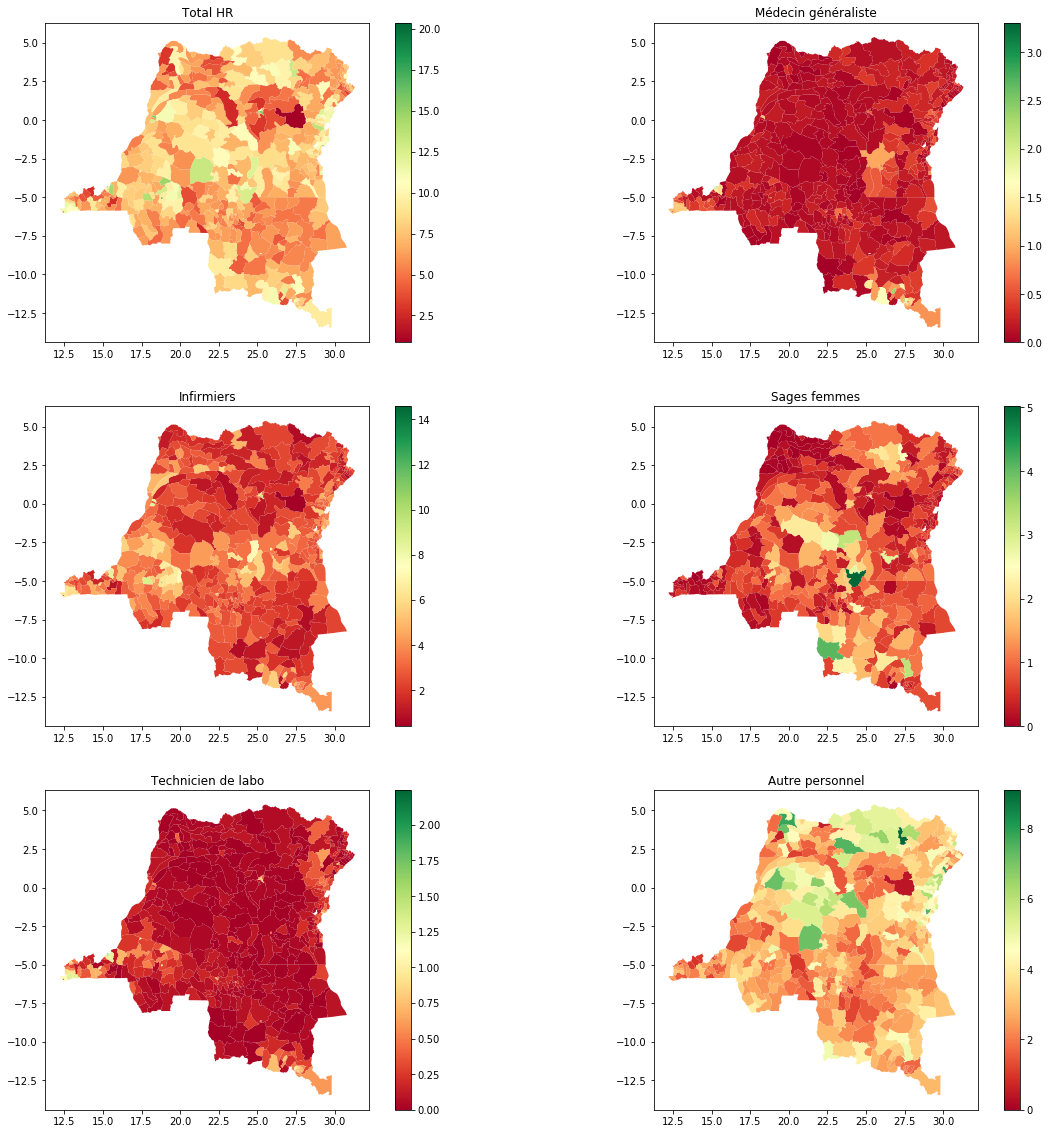

In [514]:
fig, ax = plt.subplots(3,2,figsize=(20,20))
zone_HR.plot(column = "Total HR",ax=ax[0,0], legend=True, cmap = "RdYlGn")
ax[0,0].set_title("Total HR")#, norm=LogNorm(vmin=shape_mean_zones_pay["recorded_spending"].min(),  vmax=shape_mean_zones_pay["recorded_spending"].max()))
zone_HR.plot(column = "Médecin généraliste",ax=ax[0, 1], legend=True, cmap = "RdYlGn")#, norm=LogNorm(vmin=shape_mean_zones_pay["recorded_spending"].min(),  vmax=shape_mean_zones_pay["recorded_spending"].max()))
ax[0,1].set_title("Médecin généraliste")
zone_HR.plot(column = "Infirmiers",ax=ax[1, 0], legend=True, cmap = "RdYlGn")
ax[1,0].set_title("Infirmiers")
zone_HR.plot(column = "Sages femmes",ax=ax[1, 1], legend=True, cmap = "RdYlGn")
ax[1,1].set_title("Sages femmes")
zone_HR.plot(column = "Technicien de labo",ax=ax[2, 0], legend=True, cmap = "RdYlGn")
ax[2,0].set_title("Technicien de labo")
zone_HR.plot(column = "Autre personnel",ax=ax[2, 1], legend=True, cmap = "RdYlGn")
ax[2,1].set_title("Autre personnel")

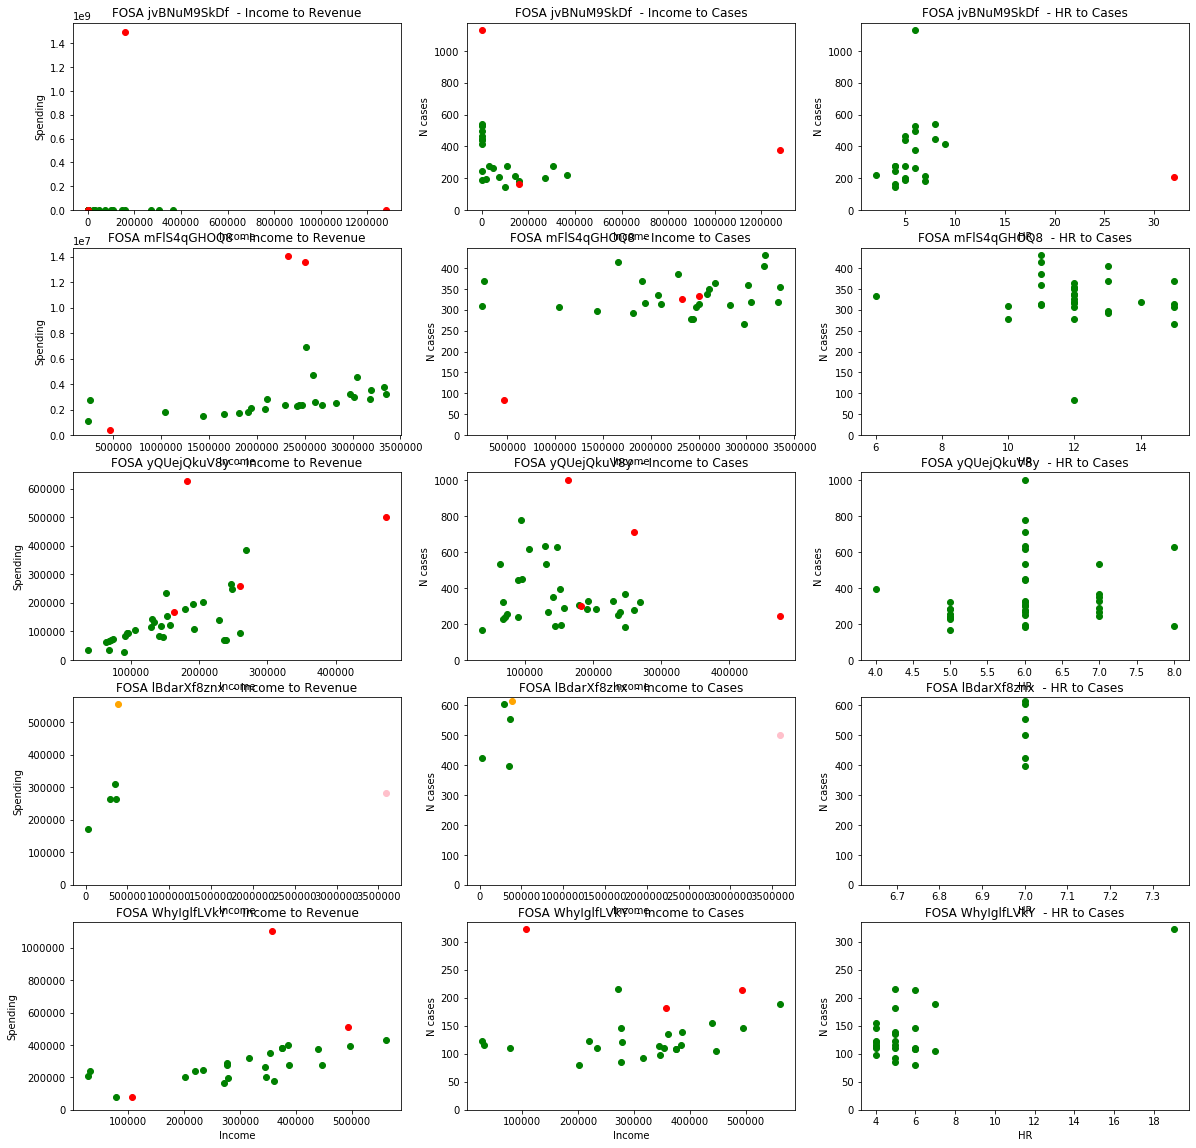

In [327]:
## Visualisation of outliers.
plt.figure(figsize=(20, 20))
for i in range(0,5):
    fosa = random.choice(list(full_outlier_data['fosa_id'].unique())) 
    plot_data = full_outlier_data[full_outlier_data.fosa_id == fosa]

 
    plt.subplot(5, 3, 1+3*i)
    plt.title("FOSA " + fosa + "  - Income to Revenue")
    plt.plot(plot_data[plot_data["outlier"] == "No"].value_revenue,plot_data[plot_data["outlier"] == "No"].value_spending, "o" , color="green")
    plt.plot(plot_data[plot_data["outlier"] == "2 levels"].value_revenue,plot_data[plot_data["outlier"] == "2 levels"].value_spending, "o", color="red")
    plt.plot(plot_data[plot_data["outlier"] == "Local Outlier"].value_revenue,plot_data[plot_data["outlier"] == "Local Outlier"].value_spending, "o", color="orange")
    plt.plot(plot_data[plot_data["outlier"] == "Global Outlier"].value_revenue,plot_data[plot_data["outlier"] == "Global Outlier"].value_spending, "o", color="pink")
    plt.ylim(0)
    plt.ylabel("Spending")
    plt.xlabel("Income")

    plt.subplot(5, 3, 2+3*i)
    plt.title("FOSA " + fosa + "  - Income to Cases")
    plt.plot(plot_data[plot_data["outlier"] == "No"].value_revenue,plot_data[plot_data["outlier"] == "No"].value_opv, "o" , color="green")
    plt.plot(plot_data[plot_data["outlier"] == "2 levels"].value_revenue,plot_data[plot_data["outlier"] == "2 levels"].value_opv, "o", color="red")
    plt.plot(plot_data[plot_data["outlier"] == "Local Outlier"].value_revenue,plot_data[plot_data["outlier"] == "Local Outlier"].value_opv, "o", color="orange")
    plt.plot(plot_data[plot_data["outlier"] == "Global Outlier"].value_revenue,plot_data[plot_data["outlier"] == "Global Outlier"].value_opv, "o", color="pink")
    plt.ylabel("N cases")
    plt.xlabel("Income")
    plt.ylim(0)
    
    hr_data = hr_full[hr_full.fosa_id == fosa]
    plt.subplot(5, 3, 3+3*i)
    plt.title("FOSA " + fosa + "  - HR to Cases")
    plt.plot(hr_data[hr_data["outlier"] == 1].value,hr_data[hr_data["outlier"] == 1].value_opv, "o" , color="green")
    plt.plot(hr_data[hr_data["outlier"] == -1].value,hr_data[hr_data["outlier"] == -1].value_opv, "o", color="red")
    plt.ylabel("N cases")
    plt.xlabel("HR")
    plt.ylim(0)

In [117]:
province_select = widgets.SelectMultiple(
    options= list(full_dat_enddate.province_name.unique()),
    value=list(full_dat_enddate.province_name.unique()),
    rows=10,
    description='Province',
    disabled=False
)

full_dat_enddate.period_end = pd.to_datetime(full_dat_enddate.period_end)
dates = sorted(full_dat_enddate.period_end.unique())
options = [(str(pd.to_datetime(i).strftime("%b-%Y")), i) for i in dates]
period_select = widgets.SelectionRangeSlider(
    options=options,
    index=(0,31),
    description='Period',
    disabled=False,
    layout=Layout(width='50%', height='80px')
)


include_outliers = widgets.RadioButtons(
    options=['keeping outliers', 'dropping ouliers'],
    description='Outliers:',
    disabled=False
)

interact(make_graph, province=province_select, period=period_select, outliers=include_outliers);

interactive(children=(SelectMultiple(description='Province', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

# Description of the health system

In [399]:
def lissage_amount(data):
    n_values=len(data)
    extrapolate_factor = 12 / n_values
    recorded_payment = 0.00060 * data.value_revenue.mean()
    extrapolated_payment = 0.00060 * extrapolate_factor * data.value_revenue.sum()
    recorded_spending = 0.00060 * data.value_spending.mean()
    extrapolated_spending = 0.00060 * extrapolate_factor * data.value_spending.sum()
    recorded_state_payment = 0.00060 * data.value_state_payment.mean()
    extrapolated_state_payment = 0.00060 * extrapolate_factor * data.value_state_payment.sum()
    recorded_opv = data.value_opv.mean()
    extrapolated_opv = extrapolate_factor * data.value_opv.sum()
    return pd.DataFrame.from_dict({"recorded_payment":[recorded_payment], "extrapolated_payment":[extrapolated_payment], "recorded_spending":[recorded_spending], 
                                   "extrapolated_spending":[extrapolated_spending], "recorded_state_payment":[recorded_state_payment], "extrapolated_state_payment":[extrapolated_state_payment],
                                  "recorded_opv":[recorded_opv], "extrapolated_opv":[extrapolated_opv]})

extrapolated_data = full_outlier_data.groupby(["province_name","zone_id","fosa_id"]).apply(lissage_amount)
extrapolated_data_not_outlier = full_outlier_data[full_outlier_data.outlier == "No"].groupby(["province_name","zone_id","fosa_id"]).apply(lissage_amount)

In [103]:
extrapolated_data["total"] = extrapolated_data[["recorded_payment","recorded_spending","recorded_state_payment"]].apply(sum, axis = 1)
extrapolated_data = extrapolated_data[(extrapolated_data["total"] > 0) & (extrapolated_data["recorded_opv"] > 0) ]

extrapolated_data_not_outlier["total"]  = extrapolated_data_not_outlier[["recorded_payment","recorded_spending","recorded_state_payment"]].apply(sum, axis = 1)
extrapolated_data_not_outlier = extrapolated_data_not_outlier[(extrapolated_data_not_outlier["total"] > 0) & (extrapolated_data_not_outlier["recorded_opv"] > 0)]

In [459]:
mean_zone_values = full_outlier_data[full_outlier_data.outlier == "No"].groupby(["province_name", "zone_id"]).apply(lissage_amount).reset_index()
mean_province_values = full_outlier_data[full_outlier_data.outlier == "No"].groupby(["province_name"]).apply(lissage_amount).reset_index()
shape_mean_zones = shape.merge(mean_zone_values, left_on="uidlevel3", right_on = "zone_id")
shape_mean_zones["spending"] = shape_mean_zones["recorded_spending"] + shape_mean_zones["recorded_state_payment"]

In [455]:
lissage_amount(full_outlier_data)

,recorded_payment,extrapolated_payment,recorded_spending,extrapolated_spending,recorded_state_payment,extrapolated_state_payment,recorded_opv,extrapolated_opv
0,895.369338,10744.432054,960.049946,11520.599355,170.657962,2047.89554,408.556613,4902.679356


In [429]:
shape_mean_zones_pay = shape_mean_zones[shape_mean_zones.recorded_spending < 3000]

In [439]:
mean_province_values

,province_name,level_1,recorded_payment,extrapolated_payment,recorded_spending,extrapolated_spending,recorded_state_payment,extrapolated_state_payment,recorded_opv,extrapolated_opv
0,bu Bas Uele Province,0,384.773099,4617.277188,382.290815,4587.489778,75.514300,906.171599,308.831014,3705.972167
1,eq Equateur Province,0,376.898648,4522.783772,361.481610,4337.779319,414.353486,4972.241829,373.462389,4481.548663
2,hk Haut Katanga Province,0,417.185820,5006.229842,549.953478,6599.441733,119.151334,1429.816011,257.343245,3088.118942
3,hl Haut Lomami Province,0,263.268087,3159.217048,264.208747,3170.504967,87.935821,1055.229855,352.905183,4234.862200
4,hu Haut Uele Province,0,708.629747,8503.556968,734.044244,8808.530925,73.008792,876.105500,202.942614,2435.311363
5,it Ituri Province,0,1071.202339,12854.428070,1311.324288,15735.891462,98.734319,1184.811832,331.786934,3981.443205
6,kc Kongo Central Province,0,637.004866,7644.058393,985.525988,11826.311861,225.545322,2706.543860,142.061142,1704.733709
7,ke Kasai Oriental Province,0,502.050059,6024.600706,518.070364,6216.844373,310.705076,3728.460913,638.918132,7667.017585
8,kg Kwango Province,0,202.760143,2433.121717,234.643351,2815.720218,49.309448,591.713373,282.245914,3386.950968
9,kl Kwilu Province,0,494.964060,5939.568716,452.355210,5428.262523,284.914077,3418.968929,313.574147,3762.889760


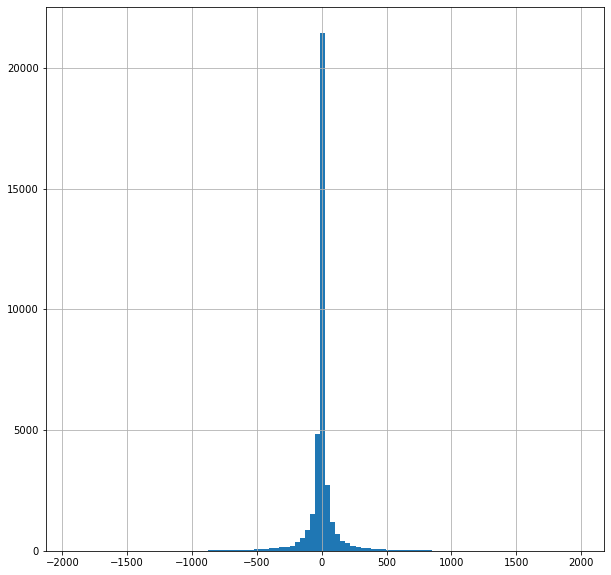

In [454]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
(extrapolated_data_not_outlier[(extrapolated_data_not_outlier.recorded_payment < 2000) & (extrapolated_data_not_outlier.recorded_spending < 2000)].recorded_payment - extrapolated_data_not_outlier[(extrapolated_data_not_outlier.recorded_payment < 2000) & (extrapolated_data_not_outlier.recorded_spending < 2000)].recorded_spending).hist(bins=100)

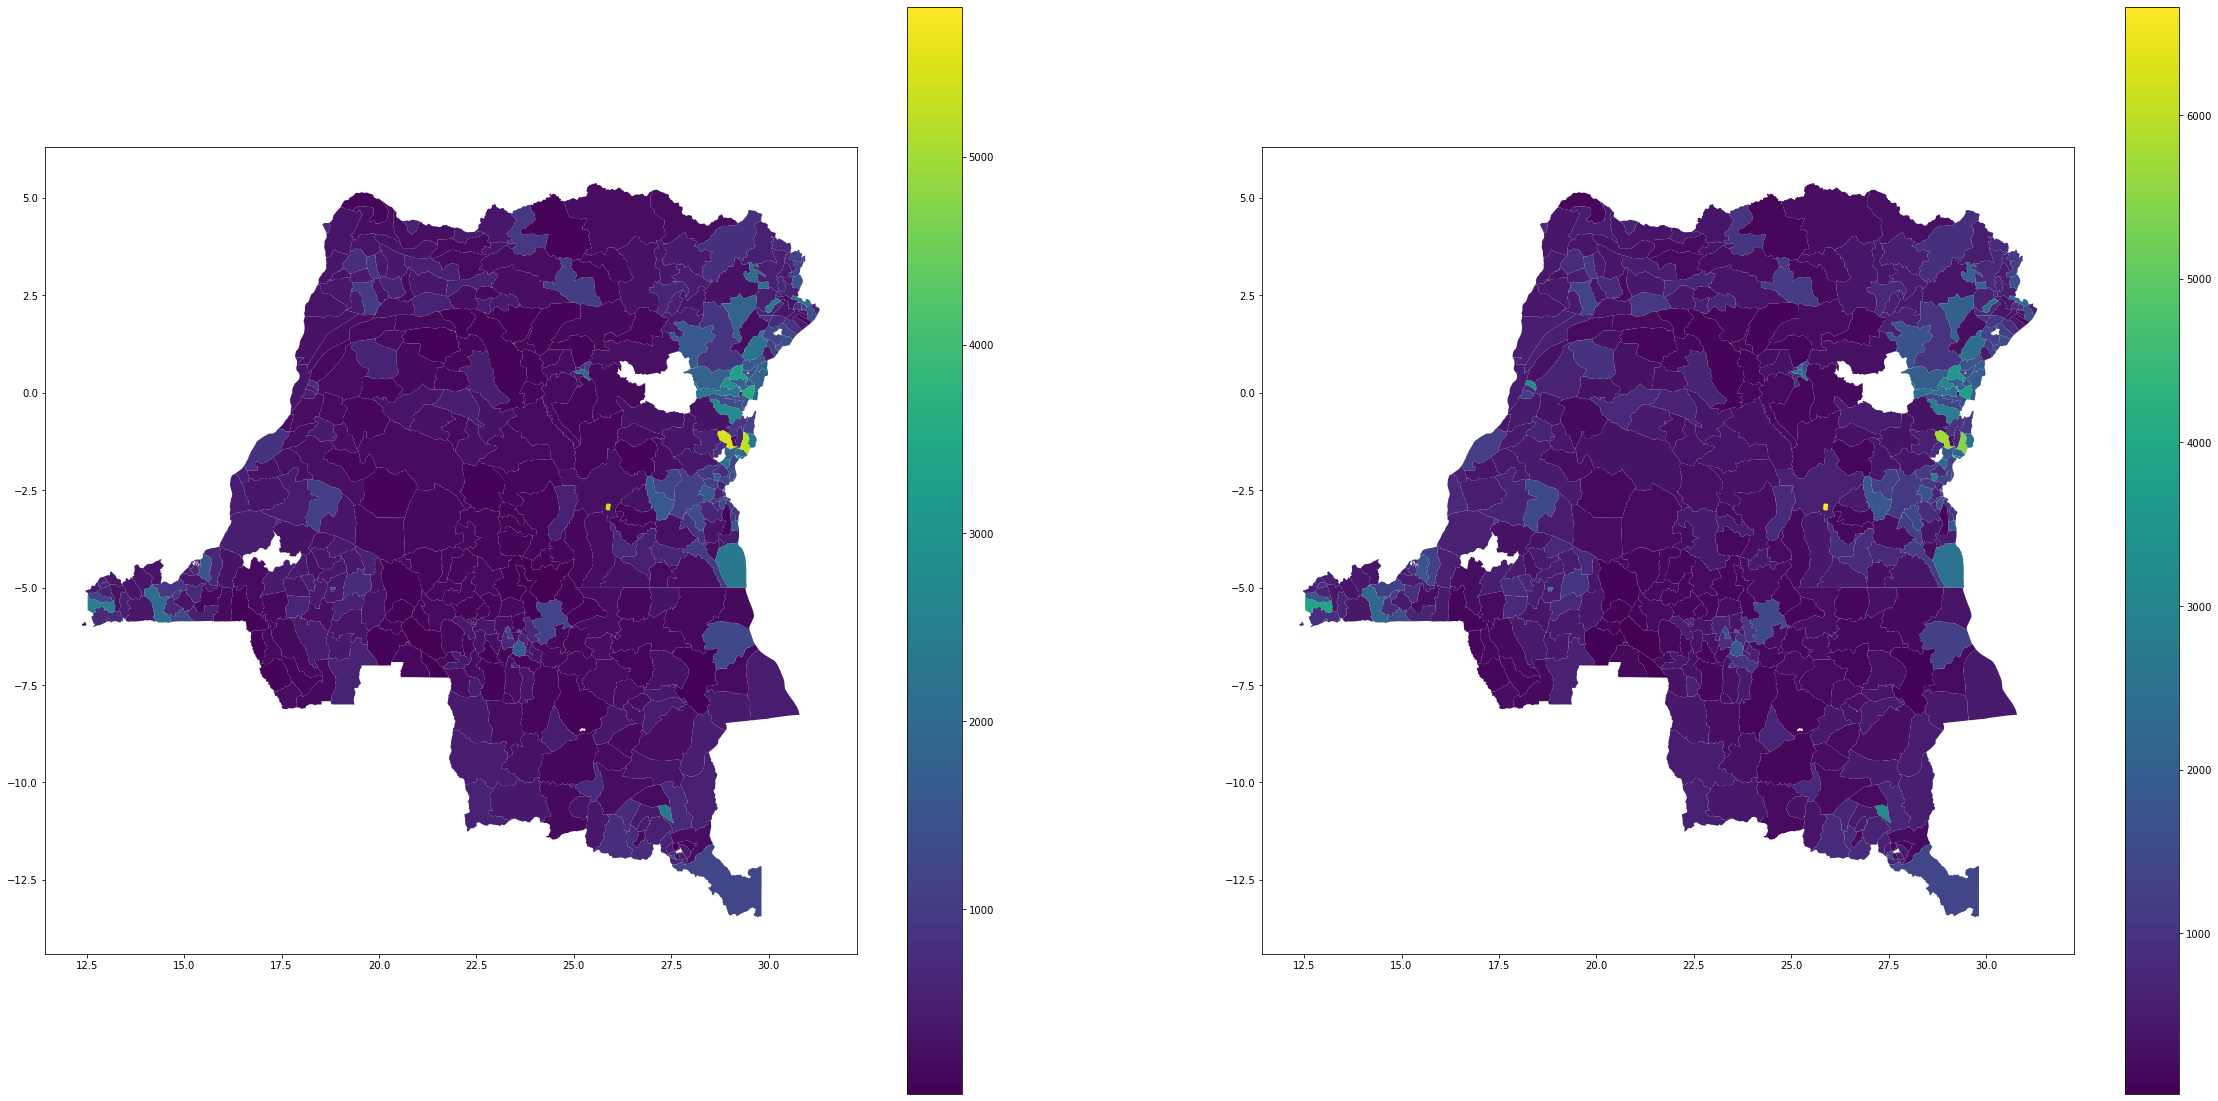

In [472]:
shape_mean_zones_pay = shape_mean_zones[(shape_mean_zones.recorded_spending > 0) & (shape_mean_zones.recorded_spending < 6000) & (shape_mean_zones.spending < 8000)]
fig, ax = plt.subplots(1,2,figsize=(40,20))
shape_mean_zones_pay.plot(column = "recorded_spending",ax=ax[0], legend=True)#, norm=LogNorm(vmin=shape_mean_zones_pay["recorded_spending"].min(),  vmax=shape_mean_zones_pay["recorded_spending"].max()))
shape_mean_zones_pay.plot(column = "spending",ax=ax[1], legend=True)#, norm=LogNorm(vmin=shape_mean_zones_pay["recorded_spending"].min(),  vmax=shape_mean_zones_pay["recorded_spending"].max()))

#provinces.plot(edgecolor = "black", color=None, alpha=1.2, ax=ax)
#sm = plt.cm.ScalarMappable(norm=LogNorm(vmin=shape_mean_zones_pay["recorded_state_payment"].min(),  vmax=shape_mean_zones_pay["recorded_state_payment"].max()))
#plt.colorbar(sm, format='%.2f', spacing='proportional')

In [542]:
def get_median_dollar_per_opv(data):
    dollar_opv = ((data.extrapolated_spending.sum() + data.extrapolated_state_payment.sum()) / data.extrapolated_opv.sum())
    #dollar_opv = dollar_opv[(dollar_opv < np.percentile(dollar_opv, .975)) & (dollar_opv > np.percentile(dollar_opv, .025))]
    return dollar_opv

In [559]:
zone_opv = extrapolated_data_not_outlier.groupby(level=[0,1]).apply(get_median_dollar_per_opv)

In [544]:
prov_opv = extrapolated_data_not_outlier.groupby(level=[0]).apply(get_median_dollar_per_opv)

In [568]:
prov_opv.reset_index()

,province_name,0
0,bu Bas Uele Province,1.478467
1,eq Equateur Province,2.129300
2,hk Haut Katanga Province,2.362152
3,hl Haut Lomami Province,0.980594
4,hu Haut Uele Province,4.179337
5,it Ituri Province,4.011025
6,kc Kongo Central Province,8.391706
7,ke Kasai Oriental Province,1.235951
8,kg Kwango Province,1.001869
9,kl Kwilu Province,2.537823


In [561]:
zone_opv = zone_opv.reset_index()
#zone_opv2 = zone_opv2.reset_index()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23364de48>]],
      dtype=object)

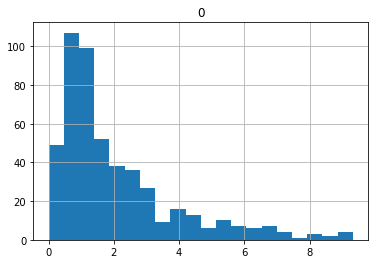

In [550]:
zone_opv.loc[zone_opv[0] < 10 & zone_opv[0] > 10].hist(bins=20)
#zone_opv2.loc[zone_opv2[0] < 10].hist(bins=20)

In [177]:
shape = gpd.read_file('drc_shape.json')

In [206]:
provinces = gpd.read_file("/Users/grlurton/Documents/data/rdc/rd_congo_admin_4_provinces.geojson")

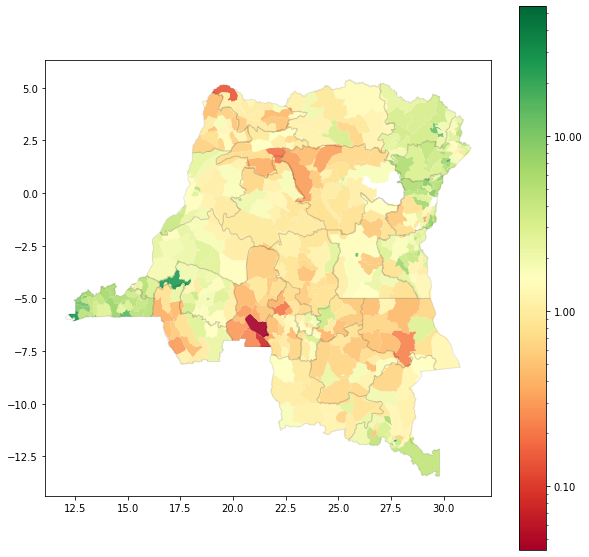

In [563]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1,figsize=(10,10))
zone_opv = zone_opv[(zone_opv[0] > 0) & (zone_opv[0] < 100)]
shape.merge(zone_opv, left_on="uidlevel3", right_on = "zone_id").plot(column=0, colormap="RdYlGn", 
                                                                      ax=ax, 
                                                                      norm=LogNorm(vmin=zone_opv[0].min(),  vmax=zone_opv[0].max()))
provinces.plot(edgecolor = "black", color="white", alpha=1.1, ax=ax)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=LogNorm(vmin=zone_opv[0].min(), vmax=zone_opv[0].max()))
plt.colorbar(sm, format='%.2f', spacing='proportional')

In [62]:
full_outlier_data.period_end = pd.to_datetime(full_outlier_data.period_end)
full_outlier_data.merge(hr_full, on = ["province_name","zone_id","fosa_id","year","period_end","period"])

,province_name,zone_id,fosa_id,year,period_end,period,value_opv_x,value_spending,value_revenue,value_state_payment,...,A 4.7 Autre personnel,A 4.7 Infirmier A1,A 4.7 Infirmier A2,A 4.7 Infirmier L2,A 4.7 Médecin généraliste,A 4.7 Nutritionnistes A2 /A1/ L2,A 4.7 Technicien de labo A2/A1/L2,value_opv_y,outlier_y,opv_per_hr
0,bu Bas Uele Province,CO06cO2i4Nm,CDFZw1dgQkw,2017,2017-02-28,201702,47.0,86950.0,66500.0,18950.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,1,7.833333
1,bu Bas Uele Province,CO06cO2i4Nm,CDFZw1dgQkw,2017,2017-04-30,201704,68.0,31000.0,37000.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,1,13.600000
2,bu Bas Uele Province,CO06cO2i4Nm,CDFZw1dgQkw,2017,2017-05-31,201705,65.0,21300.0,29000.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,1,10.833333
3,bu Bas Uele Province,CO06cO2i4Nm,CDFZw1dgQkw,2017,2017-06-30,201706,81.0,37500.0,61500.0,22000.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,1,11.571429
4,bu Bas Uele Province,CO06cO2i4Nm,CDFZw1dgQkw,2017,2017-07-31,201707,51.0,57000.0,83000.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295147,tu Tshuapa Province,sJNFC3s1djp,zvJ6gwSIyWT,2018,2018-10-31,201810,400.0,18300.0,50000.0,0.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,400.0,1,57.142857
295148,tu Tshuapa Province,sJNFC3s1djp,zvJ6gwSIyWT,2019,2019-02-28,201902,410.0,150000.0,160000.0,0.0,...,4.0,0.0,2.0,0.0,0.0,0.0,1.0,410.0,1,51.250000
295149,tu Tshuapa Province,sJNFC3s1djp,zvJ6gwSIyWT,2019,2019-06-30,201906,391.0,130000.0,180000.0,255000.0,...,2.0,0.0,2.0,0.0,0.0,0.0,1.0,391.0,1,65.166667
295150,tu Tshuapa Province,sJNFC3s1djp,zvJ6gwSIyWT,2019,2019-07-31,201907,609.0,913500.0,1068500.0,446000.0,...,6.0,0.0,2.0,0.0,0.0,0.0,0.0,609.0,1,76.125000


In [ ]:
#N Health facilities

#N Health facilities by type

#N health facilities per 10,000 population by province + distr by zone

# Aggregate resource mobilisation
#Per source
#Per capita
#Per disease areas
#External resources for health
#% national budget


#OPD N per region
#OPD per capita by region

# Comparison of Inputs and outputs

In [273]:
category_dict = {"A 4.5 Prime locale":"HR",
                 "A 4.5 Transport personnel":"HR",
                 "A 4.6 Prime de l'Etat":"HR",
                 "A 4.6 Salaire de l'Etat":"HR",
                 "A 4.5 Achat fournitures diverses":"procurement", 
                 "A 4.5 Médicaments & consommables":"procurement", 
                 "A 4.5 Paiements non stockables":"procurement", 
                 "A 4.5 Investissements":"finance & management",
                 "A 4.5 Frais bancaires":"finance & management",
                 "A 4.5 Charge sociale, impôts":"finance & management",
                 "A 4.5 Autres dépenses":"other"
                }

In [274]:
def normalized_sum(data, dimension):
    out = data.groupby(dimension).value.sum() / data.value.sum()
    return out

spending["budget_category"] = spending.data_element_name.copy()
spending.budget_category = spending.budget_category.replace(category_dict)

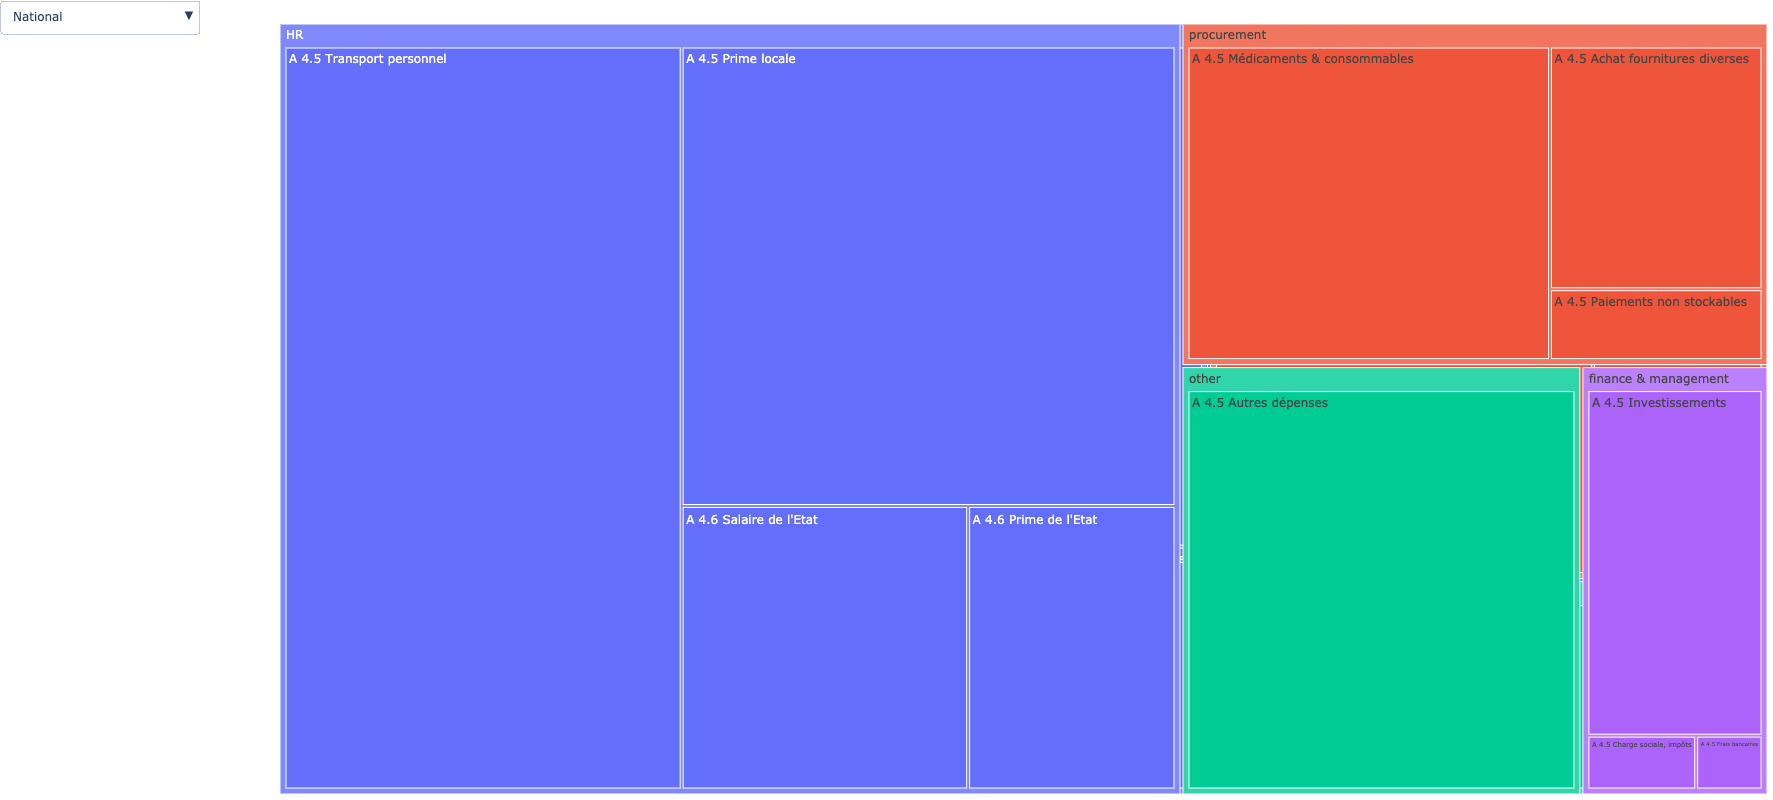

In [282]:
def make_treemap(data):
    category_values =  data.groupby("budget_category").value.sum().reset_index()
    budget_values =  data.groupby(["budget_category", "data_element_name"]).value.sum().reset_index()
    labels = budget_values.data_element_name.tolist() + category_values.budget_category.tolist()
    parents = budget_values.budget_category.tolist() + [""]*len(category_values)
    treemap = go.Treemap(labels = labels,
                         parents = parents,
                         values =  budget_values.value.apply(lambda x: 0.00060 * x).tolist() + category_values.value.apply(lambda x: 0.00060 * x).tolist(),
                         branchvalues = "total",
                         hovertemplate='<b>%{label} </b> <br> Amount (USD): %{value}<br>')
    return treemap


state_payments_budget = state_payments.copy()
state_payments_budget["budget_category"] = "HR"
spending_full = spending.append(state_payments_budget)

visible = {"National":[True]}
for prov in sorted(spending_full.province_name.unique()):
    visible[prov] = [False]

data = [make_treemap(spending_full)]
for prov in sorted(spending_full.province_name.unique()):
    plot_data = spending_full[spending_full.province_name == prov]
    for k in visible.keys():
        visible[k] = visible[k] + [k == prov]
    data = data + [make_treemap(plot_data)]


list_buttons = []
for prov in visible.keys():
    list_buttons = list_buttons + [dict(label = prov,
                                        method = "update",
                                        args =  [{"visible":visible[prov]}, {"title": prov}])]

layout = go.Layout(
    autosize=False,
    width=1000,
    height=800,
    margin=go.layout.Margin(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ),
    updatemenus=[
        go.layout.Updatemenu(
            active=0,
            buttons=list(list_buttons),
        )
    ]
)

fig = go.Figure(data= data, layout=layout)  

fig.show()

In [20]:
def normalized_sum(data, dimension):
    out = data.groupby(dimension).value.sum() / data.value.sum()
    return out

@interact
def plot_distrib(province = list(spending.province_name.unique())):
    spending_distribution = normalized_sum(spending[spending.province_name == province],"budget_category")
    plt.figure(figsize=(10,10)) ;
    spending_distribution.plot(kind="bar", stacked='True', figsize=(20,10) ).legend(bbox_to_anchor=(1.22, 1));

interactive(children=(Dropdown(description='province', options=('it Ituri Province', 'kr Kasai Central Provinc…

# Efficiency Analysis

In [ ]:
## Get outpatients services distribution
## Unsupervised learning on it to get categories of FOSA

In [57]:
hr_full.loc[hr_full.outlier == 1,"opv_per_hr"] = hr_full.value_opv / hr_full.value
hr_full.groupby("province_name").opv_per_hr.median()
#.groupby(["province_name","fosa_id"]).apply(lambda x: x.value_opv / x.value median()

province_name
bu Bas Uele Province           29.666667
eq Equateur Province           39.571429
hk Haut Katanga Province       19.833333
hl Haut Lomami Province        60.250000
hu Haut Uele Province          24.296703
it Ituri Province              37.857143
kc Kongo Central Province      20.500000
ke Kasai Oriental Province     76.401786
kg Kwango Province             34.666667
kl Kwilu Province              24.000000
kn Kinshasa Province           14.211111
kr Kasai Central Province      46.000000
ks Kasai Province              48.444444
ll Lualaba Province            32.600000
lm Lomami Province             48.333333
md Maindombe Province          31.000000
mg Mongala Province            71.333333
mn Maniema Province            31.679487
nk Nord Kivu Province          38.792857
nu Nord Ubangi Province        73.600000
sk Sud Kivu Province           49.333333
sn Sankuru Province            37.142857
su Sud Ubangi Province        112.000000
tn Tanganyika Province         49.750000
tp

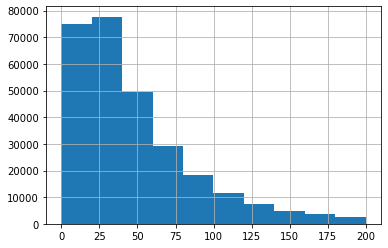

In [54]:
hr_full.opv_per_hr[hr_full.opv_per_hr < 200].hist()

In [21]:
full_dat_yearly = (full_dat_enddate.groupby(["province_name","fosa_id"]).apply(lambda x: (x.value_opv/(0.00060 * x.value_spending).median()))).reset_index()
full_dat_yearly.groupby("province_name").value_opv.median()

province_name
bu Bas Uele Province          1.540840
eq Equateur Province          2.309682
hk Haut Katanga Province      5.617978
hl Haut Lomami Province       3.523307
hu Haut Uele Province         0.679551
it Ituri Province             0.808448
kc Kongo Central Province     0.653595
ke Kasai Oriental Province    2.317708
kg Kwango Province            5.424147
kl Kwilu Province             1.336053
kn Kinshasa Province          4.804843
kr Kasai Central Province     3.500567
ks Kasai Province             5.952381
ll Lualaba Province           2.379281
lm Lomami Province            2.886656
md Maindombe Province         1.984578
mg Mongala Province           2.822876
mn Maniema Province           2.920005
nk Nord Kivu Province         0.643255
nu Nord Ubangi Province       1.656096
sk Sud Kivu Province          0.984855
sn Sankuru Province           6.051282
su Sud Ubangi Province        2.292240
tn Tanganyika Province        4.231011
tp Tshopo Province            2.417074
tu Tshuapa 